In [1]:
print("Hello World")

Hello World


In [2]:
pip install --upgrade datasets huggingface_hub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.8/494.8 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 12.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.7.0
    Uninstalling fsspec-2025.7.0:
      Successfully uninstalled fsspec-2025.7.0
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 

In [ ]:
print("Hello World")

Hello World


In [3]:
# prompt: load dataset from tungvu3196/vlm-project-with-images-with-bbox-images-v5

from huggingface_hub import notebook_login
from datasets import load_dataset

# notebook_login()
dataset = load_dataset("tungvu3196/vlm-project-with-images-with-bbox-images-v7")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00004.parquet:   0%|          | 0.00/484M [00:00<?, ?B/s]

train-00001-of-00004.parquet:   0%|          | 0.00/485M [00:00<?, ?B/s]

train-00002-of-00004.parquet:   0%|          | 0.00/485M [00:00<?, ?B/s]

train-00003-of-00004.parquet:   0%|          | 0.00/451M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/233M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/11020 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1355 [00:00<?, ? examples/s]

Loading dataset 'tungvu3196/vlm-project-with-images-with-bbox-images-with-tree-of-thoughts' to apply rotation...


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00004.parquet:   0%|          | 0.00/474M [00:00<?, ?B/s]

train-00001-of-00004.parquet:   0%|          | 0.00/474M [00:00<?, ?B/s]

train-00002-of-00004.parquet:   0%|          | 0.00/475M [00:00<?, ?B/s]

train-00003-of-00004.parquet:   0%|          | 0.00/474M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/265M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/10783 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1542 [00:00<?, ? examples/s]

Dataset loaded successfully.

Applying rotation and bbox transformation to target row in 'test' split...


Map:   0%|          | 0/1542 [00:00<?, ? examples/s]

Found target row: Patient ID='OAS1_0278', Slide='mpr-2_120'. Applying transformation...
  Transformation complete using your 'rotate90Deg' function.

Transformation applied.
Verifying the updated row...


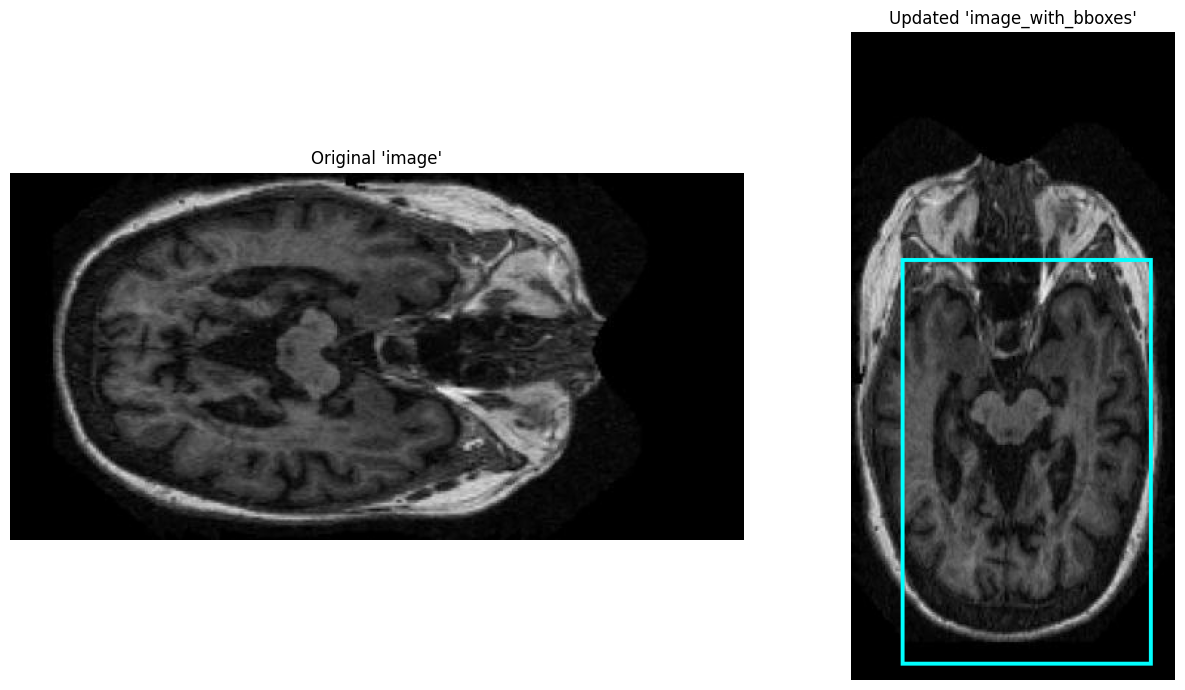

In [4]:
from datasets import load_dataset, DatasetDict, Image as HFImageFeatures
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import ast
import json

# --- Your exact transformation function ---
def rotate90Deg(bndbox_pixels, img_width):
   """
   Transforms pixel-based [xmin, ymin, xmax, ymax] bounding box coordinates
   for a 90-degree counter-clockwise rotation on a SQUARE image.
   """
   x_min, y_min, x_max, y_max = bndbox_pixels
   new_xmin = y_min
   new_ymin = img_width - x_max
   new_xmax = y_max
   new_ymax = img_width - x_min
   return [new_xmin, new_ymin, new_xmax, new_ymax]

# --- Helper Function to draw bounding boxes ---
# This function expects normalized coordinates, so it will be used after re-normalization.
def draw_bboxes_on_image_pil(image_pil, normalized_bboxes_list, box_format="xywh", color="lime", width=3):
    if not isinstance(image_pil, Image.Image): return image_pil
    draw_image = image_pil.copy()
    draw = ImageDraw.Draw(draw_image)
    img_width, img_height = image_pil.size
    for bbox_norm in normalized_bboxes_list:
        if len(bbox_norm) != 4: continue
        try: coords = [float(c) for c in bbox_norm]
        except (ValueError, TypeError): continue
        if box_format == "minmax":
            xmin, ymin, xmax, ymax = coords
            draw.rectangle([(xmin * img_width, ymin * img_height), (xmax * img_width, ymax * img_height)], outline=color, width=width)
        elif box_format == "xywh":
            xc_norm, yc_norm, w_norm, h_norm = coords
            abs_w, abs_h = w_norm * img_width, h_norm * img_height
            abs_xc, abs_yc = xc_norm * img_width, yc_norm * img_height
            abs_xmin, abs_ymin = abs_xc - (abs_w / 2), abs_yc - (abs_h / 2)
            draw.rectangle([(abs_xmin, abs_ymin), (abs_xmin + abs_w, abs_ymin + abs_h)], outline=color, width=width)
    return draw_image


# --- Main processing function to be used with .map() ---
def rotate_and_transform_bboxes_with_user_func(example, target_patient_id, target_slide, bbox_format="xywh"):
    current_patient_id = example.get("Patient ID")
    current_slide = example.get("Slide")

    if current_patient_id == target_patient_id and current_slide == target_slide:
        print(f"Found target row: Patient ID='{current_patient_id}', Slide='{current_slide}'. Applying transformation...")

        original_image_pil = example.get('image')
        bbox_str = example.get('Bbox coordinates normalized (X, Y, W, H)')

        if not isinstance(original_image_pil, Image.Image) or not isinstance(bbox_str, str) or not bbox_str:
            print("  Warning: Invalid data in the target row. Skipping."); return example

        original_width, original_height = original_image_pil.size
        # Your function assumes a square image. We should add a check.
        if original_width != original_height:
            print(f"  Warning: Image for {current_patient_id} is NOT SQUARE ({original_width}x{original_height}). "
                  f"Your 'rotate90Deg' function might produce unexpected results.")
            # The logic inside rotate90Deg implicitly assumes new canvas width = new canvas height = old width.
            # For a non-square image, this will be incorrect.

        try:
            parsed_bbox_data = ast.literal_eval(bbox_str)
            original_bboxes_norm = []
            if parsed_bbox_data and isinstance(parsed_bbox_data[0], list):
                if parsed_bbox_data[0] and isinstance(parsed_bbox_data[0][0], list): original_bboxes_norm = parsed_bbox_data[0]
                else: original_bboxes_norm = parsed_bbox_data
        except Exception as e:
            print(f"  Error parsing bbox string '{bbox_str}': {e}. Skipping."); return example

        transformed_bboxes_norm = [] # To store the final re-normalized boxes

        for bbox_norm in original_bboxes_norm:
            # --- Integration Step 1: De-normalize ---
            if bbox_format == "xywh":
                xc_norm, yc_norm, w_norm, h_norm = bbox_norm
                xmin_px = (xc_norm - w_norm / 2) * original_width
                ymin_px = (yc_norm - h_norm / 2) * original_height
                xmax_px = (xc_norm + w_norm / 2) * original_width
                ymax_px = (yc_norm + h_norm / 2) * original_height
            elif bbox_format == "minmax":
                xmin_norm, ymin_norm, xmax_norm, ymax_norm = bbox_norm
                xmin_px = xmin_norm * original_width
                ymin_px = ymin_norm * original_height
                xmax_px = xmax_norm * original_width
                ymax_px = ymax_norm * original_height
            else: continue

            original_bbox_pixels = [xmin_px, ymin_px, xmax_px, ymax_px]

            # --- Integration Step 2: Apply your pixel-space transformation function ---
            # NOTE: We pass original_width, as per your function's signature.
            transformed_bbox_pixels = rotate90Deg(original_bbox_pixels, original_width)

            # --- Integration Step 3: Re-normalize ---
            new_width, new_height = original_height, original_width
            if new_width == 0 or new_height == 0: continue # Avoid division by zero

            new_xmin_px, new_ymin_px, new_xmax_px, new_ymax_px = transformed_bbox_pixels

            if bbox_format == "xywh":
                new_w_px = new_xmax_px - new_xmin_px
                new_h_px = new_ymax_px - new_ymin_px
                new_xc_px = new_xmin_px + new_w_px / 2
                new_yc_px = new_ymin_px + new_h_px / 2
                transformed_bboxes_norm.append([
                    new_xc_px / new_width,
                    new_yc_px / new_height,
                    new_w_px / new_width,
                    new_h_px / new_height
                ])
            elif bbox_format == "minmax":
                 transformed_bboxes_norm.append([
                    new_xmin_px / new_width,
                    new_ymin_px / new_height,
                    new_xmax_px / new_width,
                    new_ymax_px / new_height
                ])

        # --- Update the example with new data ---
        rotated_image_pil = original_image_pil.rotate(90, expand=True)
        example['image'] = rotated_image_pil
        example['Bbox coordinates normalized (X, Y, W, H)'] = json.dumps(transformed_bboxes_norm)
        image_with_transformed_bboxes = draw_bboxes_on_image_pil(
            rotated_image_pil,
            transformed_bboxes_norm,
            box_format=bbox_format,
            color="cyan"
        )
        example['image_with_bboxes'] = image_with_transformed_bboxes
        print("  Transformation complete using your 'rotate90Deg' function.")

    return example


# --- Main Script ---
HF_DATASET_NAME = "tungvu3196/vlm-project-with-images-with-bbox-images-with-tree-of-thoughts"
TARGET_PATIENT_ID = 'OAS1_0278'
TARGET_SLIDE = 'mpr-2_120'
BBOX_FORMAT = "xywh" # <<<--- CRITICAL: Set to "minmax" if your data is [xmin, ymin, xmax, ymax]

print(f"Loading dataset '{HF_DATASET_NAME}' to apply rotation...")
try:
    hf_dataset_dict = load_dataset(HF_DATASET_NAME)
    print("Dataset loaded successfully.")
except Exception as e:
    print(f"An error occurred loading dataset: {e}"); exit()

if 'test' in hf_dataset_dict:
    print(f"\nApplying rotation and bbox transformation to target row in 'test' split...")
    test_split_original = hf_dataset_dict['test']
    features = test_split_original.features.copy()
    features['image'] = HFImageFeatures()
    features['image_with_bboxes'] = HFImageFeatures()

    test_split_updated = test_split_original.map(
        lambda ex: rotate_and_transform_bboxes_with_user_func(
            ex,
            target_patient_id=TARGET_PATIENT_ID,
            target_slide=TARGET_SLIDE,
            bbox_format=BBOX_FORMAT
        ),
        features=features
    )
    print("\nTransformation applied.")

    # --- Verification ---
    # ... (Verification code remains the same, it will display the final result) ...
    print("Verifying the updated row...")
    updated_row_found = False
    for example in test_split_updated:
        if example.get("Patient ID") == TARGET_PATIENT_ID and example.get("Slide") == TARGET_SLIDE:
            updated_row_found = True

            original_target_image = None
            for original_ex in test_split_original:
                 if original_ex.get("Patient ID") == TARGET_PATIENT_ID and original_ex.get("Slide") == TARGET_SLIDE:
                     original_target_image = original_ex.get('image')
                     break

            updated_image_with_bboxes = example.get('image_with_bboxes')

            fig, axes = plt.subplots(1, 2, figsize=(14, 7))
            axes[0].imshow(original_target_image); axes[0].set_title("Original 'image'"); axes[0].axis('off')
            axes[1].imshow(updated_image_with_bboxes); axes[1].set_title("Updated 'image_with_bboxes'"); axes[1].axis('off')
            plt.tight_layout(); plt.show()
            break

    if not updated_row_found:
        print("Could not find the target row in the updated dataset for verification.")
else:
    print("'test' split not found in the dataset.")